In [25]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib import colors
from numba import njit

Notes:

- **Do vertical drainage first**
- **If water go to cell with no ice -> lose water:** *If meltwater is transported by horizontal drainage into a cell where the ice thickness is zero, the meltwater is assumed to enter the ocean and is lost.*
- **If no amount of water meant to flow horizontally < available water -> use max available:** *If the amount of horizontal drainage from one grid cell to its neighbors, predicted by equation (2), is greater than the amount of water available, the total amount of horizontal drainage is set equal to the water available after melting and seepage.*

In [26]:
# 7, 3 as placeholder for values

H_t = 0 # upper surface of the ice block
H_b = -7 # lower surface of the ice block
H = H_t - H_b # depth of the ice block

h = 7 # height of the water layer
H_ref = -3 # distance between top layer and average ice height
x,y = 0,0 # later lattice; coordinates

# constants set in some figure
m_i = 1.2 / (3600 * 24) # cm/day; unpounded ice melt rate
m_p = 2 # cm/day; maximum melt pond enhanced melt rate


# simplifications
m = m_i # should really follow equation 4


equation_3_delta_h = lambda input: 0.2
equation_4_m = lambda input: 7
equation_6_delta_H = lambda input: 0.2

In [27]:
@njit
def calc_psi(H_t,h,H_ref):
  """
  Calculate (initial) psi/ surface-to-reference distance.
  """
  return H_t + h - H_ref

@njit
def melt_rate(m_p, m_i, h, h_max):
    """
    Calculate total melt rate m based on albedo of melt ponds.
    if h > h_max:
      return 1+ m_p/m_i
    else:
      return 1+ m_p/m_i * h/h_max
    :param m_p: enhancement factor due to the presence of melt ponds
    :param m_i:
    :param h:
    :param h_max: pond depth
    :return:
    """
    return np.where(h>h_max,1+ m_p/m_i, 1+ m_p/m_i * h/h_max)


In [28]:
@njit
def first_derivative_centered(x, dx, axis = 0):
    '''
    Calculates the first spatial derivative with a centered difference scheme along the given axis for a 2D array.
    Assumes periodic boundaries

    Arguments:
        x -- 2D array
        dx -- spatial increment
        axis -- axis along which to derive

    Returns:
        der -- 2D array
    '''

    der = (np.roll(x, -1, axis=axis) - np.roll(x, 1, axis=axis)) / 2*dx

    return der

@njit
def grad_dot_h(h, psi, dx):
    '''
    Calculates the Nabla part of equation 3 int Luethje et al. 2006

    Arguments:
        h -- 2D array of meltwater height
        psi -- 2D array of topography
        dx -- spatial increment

    Returns:
        grad -- the Nabla part of equation 3 int Luethje et al. 2006
    '''

    # get the gradient of psi
    psi_dx = h* first_derivative_centered(psi, dx, axis = 1)
    psi_dy = h* first_derivative_centered(psi, dx, axis = 0)

    # calculate the dot product of the gradient with the gradient of psi
    grad = first_derivative_centered(psi_dx, dx, axis= 1) + first_derivative_centered(psi_dy, dx, axis= 0)

    return grad

In [29]:
@njit
def heaviside(h):
    """
    Prevents the meltwater depth h from becoming negative.
    """
    return np.where(h < 0, 0, 1)


In [30]:
rho_water = 1000
rho_ice = 900
s = 0.8 / (3600 * 24)
pi_h = 3e-9 # horizontal permeability
delta_x = 1

@njit
def calc_H0(psi,rho_ice,rho_water):
    """
    Initial ice thickness by assuming hydrostatic equilibrium.
    :param psi:
    :param rho_ice:
    :param rho_water:
    :return:
    """
    return psi/(1-(rho_ice/rho_water))

# @njit
def calc_dhdt(h,rho_water,rho_ice,s,pi_h, psi, m, delta_x):
    """
    Conservation of mass of the meltwater.
    :param rho_water:`
    :param rho_ice:
    :param s: vertical seepage rate
    :param m: melting rate
    :param pi_h: horizontal permeability of sea ice
    :return: 2DArray of dhdt
    """
    g = 9.80665
    mu = 1.79e-3 # dynamic viscosity
    hor_flux = g*rho_water/mu * pi_h # horizontal mass flux per unit cross sectional area
    inside = -s + rho_ice*m/rho_water - hor_flux * grad_dot_h(h, psi, delta_x)
    return heaviside(h)*(inside)

@njit
def calc_dHtdt(H,m):
  """
  Update of ice-surface height.
  :param H: ice-surface height at current time
  :param m: melting rate
  """
  return heaviside(H)*-m

def next_Ht(dHtdt,delta_t,H_t):
  return dHtdt*delta_t + H_t


@njit
def next_h(dhdt,delta_t,h):
  """
  Calculate next value of h.
  :param dhdt: Conservation of mass of the meltwater.
  :param delta_t: difference in time t between steps
  :param h: current value of h
  """
  return dhdt*delta_t + h

Testing

In [31]:
# need:
  # 2D array of h

delta_t = 60

# h = np.array([[0.2, 0.2, 0.2],
#              [0.2, 0.25, 0.2],
#              [0.2, 0.2, 0.2]])

size = 1000

h = np.random.normal(loc = 0, scale = 0.05, size = (size, size))
h = heaviside(h) * h

H0 = np.ones(h.shape)
H_ref = np.zeros(h.shape)
init_psi = calc_psi(H0, h, H_ref)

Ht = H0
psi= init_psi

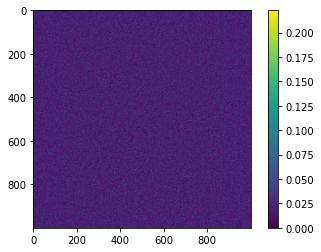

In [32]:
plt.imshow(h)
plt.colorbar()

In [33]:
for _ in range(3000):
  dhdt = calc_dhdt(h,rho_water,rho_ice,s,pi_h, psi, m, delta_x)
  cur_h = next_h(dhdt,delta_t,h)
  Ht = next_Ht(calc_dHtdt(Ht,m),delta_t,Ht)
  h = cur_h
  psi = calc_psi(Ht, h, H_ref)

plt.imshow(h)
plt.colorbar()

TypingError: Failed in nopython mode pipeline (step: nopython frontend)
[1m[1m[1m[1mFailed in nopython mode pipeline (step: nopython frontend)
[1m[1m[1mNo implementation of function Function(<function roll at 0x7f911b74baf0>) found for signature:
 
 >>> roll(array(float64, 2d, C), Literal[int](-1), axis=Literal[int](1))
 
There are 2 candidate implementations:
[1m      - Of which 2 did not match due to:
      Overload in function 'np_roll': File: numba/np/arraymath.py: Line 2126.
        With argument(s): '(array(float64, 2d, C), int64, axis=int64)':[0m
[1m       Rejected as the implementation raised a specific error:
         TypingError: [1mgot an unexpected keyword argument 'axis'[0m[0m
  raised from /home/maistro/anaconda3/lib/python3.9/site-packages/numba/core/typing/templates.py:791
[0m
[0m[1mDuring: resolving callee type: Function(<function roll at 0x7f911b74baf0>)[0m
[0m[1mDuring: typing of call at /tmp/ipykernel_24231/491179501.py (16)
[0m
[1m
File "../../../../tmp/ipykernel_24231/491179501.py", line 16:[0m
[1m<source missing, REPL/exec in use?>[0m

[0m[1mDuring: resolving callee type: type(CPUDispatcher(<function first_derivative_centered at 0x7f90e3da1670>))[0m
[0m[1mDuring: typing of call at /tmp/ipykernel_24231/491179501.py (35)
[0m
[0m[1mDuring: resolving callee type: type(CPUDispatcher(<function first_derivative_centered at 0x7f90e3da1670>))[0m
[0m[1mDuring: typing of call at /tmp/ipykernel_24231/491179501.py (35)
[0m
[1m
File "../../../../tmp/ipykernel_24231/491179501.py", line 35:[0m
[1m<source missing, REPL/exec in use?>[0m


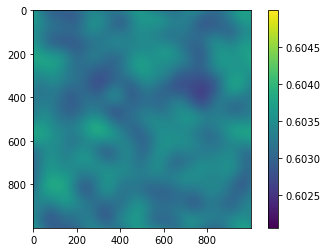

In [ ]:
plt.imshow(psi)
plt.colorbar()

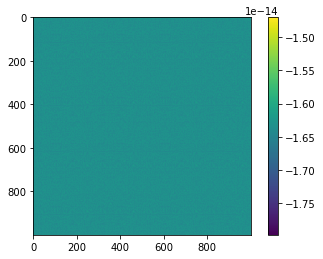

In [ ]:
plt.imshow(Ht)
plt.colorbar()

In [ ]:
psi

array([[0.6032673 , 0.60383918, 0.60324776, ..., 0.60384537, 0.60328679,
        0.60384269],
       [0.60390436, 0.60334152, 0.60387509, ..., 0.60334258, 0.60393227,
        0.60334221],
       [0.60326728, 0.60384234, 0.60324815, ..., 0.60384742, 0.6032864 ,
        0.6038453 ],
       ...,
       [0.60385118, 0.60334782, 0.60382235, ..., 0.60334783, 0.60387869,
        0.60334798],
       [0.60326705, 0.60383534, 0.60324711, ..., 0.60384266, 0.60328692,
        0.6038394 ],
       [0.60387825, 0.60334427, 0.60384918, ..., 0.60334484, 0.60390598,
        0.60334471]])

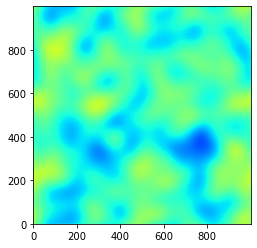

In [ ]:

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# Define the animation update function
def update(frame):
    global h
    psi = calc_psi(np.ones(h.shape), h, np.zeros(h.shape))
    dhdt = calc_dhdt(rho_water, rho_ice, s, pi_h, psi, m, delta_x)
    h = next_h(dhdt, delta_t, h)
    im.set_array(h)
    return im,

# Initialize the figure
fig, ax = plt.subplots()
im = ax.imshow(h, cmap='jet', origin='lower')

# Set the animation interval and create the animation
animation = FuncAnimation(fig, update, frames=range(100), interval=200)

# Display the animation
plt.show()

In [ ]:
h

array([[0.6032673 , 0.60383918, 0.60324776, ..., 0.60384537, 0.60328679,
        0.60384269],
       [0.60390436, 0.60334152, 0.60387509, ..., 0.60334258, 0.60393227,
        0.60334221],
       [0.60326728, 0.60384234, 0.60324815, ..., 0.60384742, 0.6032864 ,
        0.6038453 ],
       ...,
       [0.60385118, 0.60334782, 0.60382235, ..., 0.60334783, 0.60387869,
        0.60334798],
       [0.60326705, 0.60383534, 0.60324711, ..., 0.60384266, 0.60328692,
        0.6038394 ],
       [0.60387825, 0.60334427, 0.60384918, ..., 0.60334484, 0.60390598,
        0.60334471]])